In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
df = pd.read_csv(r'C:\Users\M\Desktop\ironhacker\final-project\final2.csv')
df

,date,open,high,low,close,volume,total_value,weighted_price
0,2014-11-28,363.59,381.34,360.57,376.28,8617.15,3.220878e+06,373.775341
1,2014-11-29,376.42,386.60,372.25,376.72,7245.19,2.746157e+06,379.031751
2,2014-11-30,376.57,381.99,373.32,373.34,3046.33,1.145567e+06,376.048101
3,2014-12-01,376.40,382.31,373.03,378.39,6660.56,2.520662e+06,378.446012
4,2014-12-02,378.39,382.86,375.23,379.25,6832.53,2.593576e+06,379.592400
...,...,...,...,...,...,...,...,...
3620,2024-10-26,66577.77,67366.46,66343.25,67014.72,14159.11,9.464474e+08,66843.706537
3621,2024-10-27,67014.72,68254.55,66852.50,67945.14,12105.31,8.185810e+08,67621.647951
3622,2024-10-28,67945.14,70241.74,67541.00,69925.83,42091.94,2.902994e+09,68967.932842
3623,2024-10-29,69925.83,73612.24,69725.05,72723.67,58289.36,4.194343e+09,71957.271337


In [4]:
# Convert date column to datetime and set it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Using 'close' price as the target variable
data = df[['close']]

# Normalize the data for better performance of the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
# using a 60-day lookback period for predicting the next day price
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Inverse transform the true values
y_train_actual = scaler.inverse_transform([y_train])
y_test_actual = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train_actual[0], train_predictions[:, 0]))
test_rmse = sqrt(mean_squared_error(y_test_actual[0], test_predictions[:, 0]))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Epoch 1/10
90/90 [==============================] - 8s 35ms/step - loss: 0.0052
Epoch 2/10
90/90 [==============================] - 3s 35ms/step - loss: 7.0472e-04
Epoch 3/10
90/90 [==============================] - 3s 36ms/step - loss: 5.9284e-04
Epoch 4/10
90/90 [==============================] - 3s 35ms/step - loss: 4.8427e-04
Epoch 5/10
90/90 [==============================] - 3s 36ms/step - loss: 4.5475e-04
Epoch 6/10
90/90 [==============================] - 3s 37ms/step - loss: 4.1604e-04
Epoch 7/10
90/90 [==============================] - 3s 36ms/step - loss: 3.8156e-04
Epoch 8/10
90/90 [==============================] - 3s 35ms/step - loss: 3.8601e-04
Epoch 9/10
90/90 [==============================] - 3s 35ms/step - loss: 3.1539e-04
Epoch 10/10
23/23 [==============================] - 0s 15ms/step
Train RMSE: 1183.3795597384033
Test RMSE: 1730.6140868056568


In [8]:
# Predict the next 30 days
predictions_30_days = []
last_lookback_data = scaled_data[-lookback:].reshape(1, lookback, 1)

for _ in range(30):
    next_pred = model.predict(last_lookback_data)[0, 0]
    predictions_30_days.append(next_pred)
    
# Reshape `next_pred` to (1, 1, 1) before appending
    next_pred_reshaped = np.array([[[next_pred]]])
    last_lookback_data = np.append(last_lookback_data[:, 1:, :], next_pred_reshaped, axis=1)

# Inverse transform the predictions to get actual price values
predictions_30_days = scaler.inverse_transform(np.array(predictions_30_days).reshape(-1, 1))



1/1 [==============================] - 0s 26ms/step


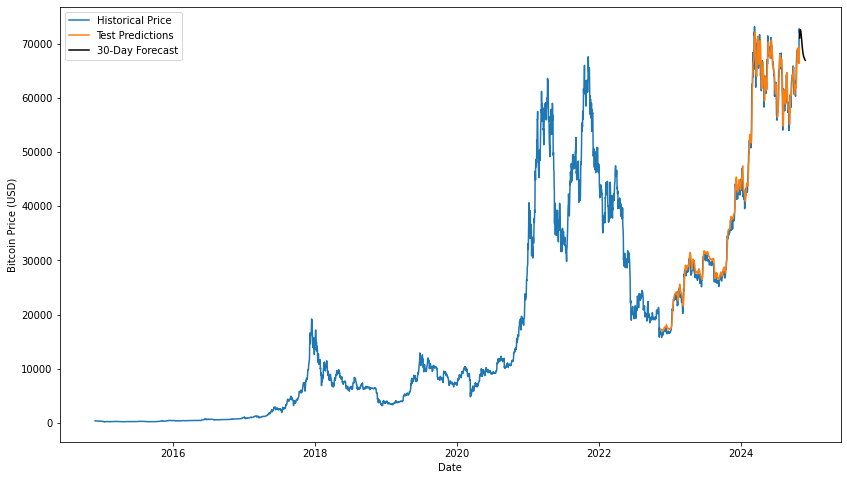

In [14]:
# Visualization
# Plot historical data, test predictions, and 30-day forecast
plt.figure(figsize=(14, 8))
plt.plot(data.index, data['close'], label='Historical Price')
plt.plot(data.index[train_size+lookback:], test_predictions, label='Test Predictions')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
plt.plot(future_dates, predictions_30_days, label='30-Day Forecast', color='black')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.show()


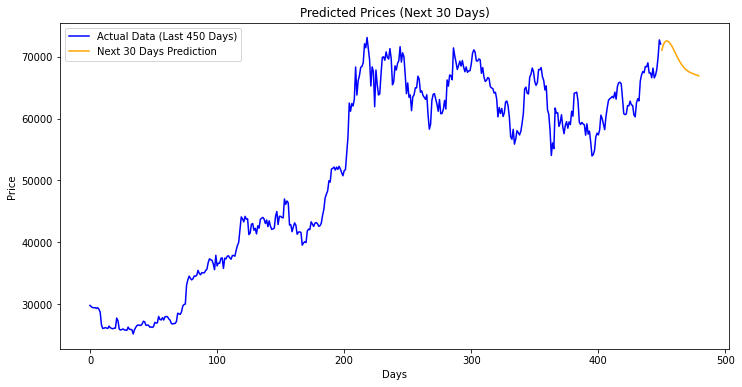

In [16]:
#To create a more focused plot
actual_last_450_days = np.array(data[-450:])

# Combine the actual last 450 days with the 30-day predictions
actual_and_predicted = np.concatenate([actual_last_450_days, predictions_30_days])

# Define the time range for plotting
days_actual = np.arange(len(actual_last_450_days)) 
days_predicted = np.arange(len(actual_last_450_days), len(actual_last_450_days) + 30)

# Plot the actual last 450 days in blue and the next 30-day predictions in orange
plt.figure(figsize=(12, 6))
plt.plot(days_actual, actual_last_450_days, color='blue', label='Actual Data (Last 450 Days)')
plt.plot(days_predicted, predictions_30_days, color='orange', label='Next 30 Days Prediction')

# Add labels and legend
plt.title('Predicted Prices (Next 30 Days)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Check scaler on only 'close' column to confirm scaling of target variable(to extract data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['close']])

# Prepare the data for LSTM with a lookback period of 60 days
lookback = 60
X, y = [], []

for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM model and split into train and test
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the LSTM model (assuming model code provided)
model.fit(X_train, y_train, batch_size=32, epochs=10)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Double-check the shape before inverse transforming
y_test_reshaped = y_test.reshape(-1, 1)  # Reshape y_test to (n, 1)
test_predictions_reshaped = test_predictions.reshape(-1, 1)  # Reshape predictions to (n, 1)

# Apply inverse transform to get the actual prices
y_test_actual = scaler.inverse_transform(y_test_reshaped).flatten()
y_pred_lstm_actual = scaler.inverse_transform(test_predictions_reshaped).flatten()

# Create DataFrame and save to CSV with clear column names
lstm_test_data = pd.DataFrame({
    'Test_Index': np.arange(len(y_test_actual)),       # Index for each test observation
    'y_test_actual': y_test_actual,                    # Actual y_test values after inverse transformation
    'y_pred_lstm_actual': y_pred_lstm_actual           # Predicted y_test values after inverse transformation
})

# Export to CSV
lstm_test_data.to_csv(r'C:\Users\M\Desktop\ironhacker\final-project\lstm_model_test_data445.csv', index=False)

Epoch 1/10
90/90 [==============================] - 3s 36ms/step - loss: 3.9386e-04
Epoch 2/10
90/90 [==============================] - 3s 33ms/step - loss: 3.6863e-04
Epoch 3/10
90/90 [==============================] - 3s 33ms/step - loss: 3.0631e-04
Epoch 4/10
90/90 [==============================] - 3s 33ms/step - loss: 3.0673e-04
Epoch 5/10
90/90 [==============================] - 3s 34ms/step - loss: 3.0816e-04
Epoch 6/10
90/90 [==============================] - 3s 33ms/step - loss: 2.6125e-04
Epoch 7/10
90/90 [==============================] - 3s 34ms/step - loss: 2.7161e-04
Epoch 8/10
90/90 [==============================] - 3s 34ms/step - loss: 2.5895e-04
Epoch 9/10
90/90 [==============================] - 3s 34ms/step - loss: 2.5362e-04
Epoch 10/10
23/23 [==============================] - 0s 14ms/step


In [31]:
# Adding more features , however the first model reached the better RMSE
# Convert date column to datetime and set it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Add a 7-day moving average of 'close' to the dataframe as a new feature
df['close_ma7'] = df['close'].rolling(window=7).mean()

# Drop initial NaN rows caused by moving average
df = df.dropna()

# Define features (including moving average) and target- however the first model reached the better RMSE
features = ['volume', 'close_ma7']
target_column = 'close'
data = df[features + [target_column]]

# Scale the feature columns separately from the target column to avoid data leakage
feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_features = feature_scaler.fit_transform(data[features])
scaled_target = target_scaler.fit_transform(data[[target_column]])

# Prepare the data for LSTM with a 60-day lookback period
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_features)):
    X.append(scaled_features[i - lookback:i])  # Use scaled features as input
    y.append(scaled_target[i, 0])              # Use scaled 'close' as the target

# Convert lists to numpy arrays
X, y = np.array(X), np.array(y)

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values for evaluation
train_predictions_actual = target_scaler.inverse_transform(train_predictions)
test_predictions_actual = target_scaler.inverse_transform(test_predictions)
y_train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = sqrt(mean_squared_error(y_train_actual, train_predictions_actual))
test_rmse = sqrt(mean_squared_error(y_test_actual, test_predictions_actual))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Epoch 1/10
89/89 [==============================] - 8s 39ms/step - loss: 0.0027
Epoch 2/10
89/89 [==============================] - 3s 39ms/step - loss: 7.2572e-04
Epoch 3/10
89/89 [==============================] - 3s 38ms/step - loss: 5.5193e-04
Epoch 4/10
89/89 [==============================] - 4s 39ms/step - loss: 5.0694e-04
Epoch 5/10
89/89 [==============================] - 4s 44ms/step - loss: 5.2587e-04
Epoch 6/10
89/89 [==============================] - 4s 41ms/step - loss: 4.9559e-04
Epoch 7/10
89/89 [==============================] - 4s 42ms/step - loss: 4.3251e-04
Epoch 8/10
89/89 [==============================] - 4s 42ms/step - loss: 3.8462e-04
Epoch 9/10
89/89 [==============================] - 4s 41ms/step - loss: 3.6344e-04
Epoch 10/10
23/23 [==============================] - 0s 15ms/step
Train RMSE: 1274.073759192264
Test RMSE: 1813.252764131419
